# Inference Sampling
- The notebook visualizes the Recall and MRR metrics at every possible cutoff for different negative sampling sizes (or even techniques)
- This helps us to better understand how different sample sizes affect model performance:
    - Recall and MRR scores
    - Relative model ranking

In [1]:
# Before running the example notebook the following commands must be executed:
# ! python data/coveo_preproc.py -p data/data_sources/coveo_ecommerce
# ! THEANO_FLAGS=device=cuda0 python inference_sampling.py --test_path data/data_sources/coveo_ecommerce/coveo_processed_view_test.tsv --train_path data/data_sources/coveo_ecommerce/coveo_processed_view_train_full.tsv --model_path data/models/coveo_optuna_mrr_bprmax_constrained_fulltrain.pickle
# ! THEANO_FLAGS=device=cuda0 python inference_sampling.py --test_path data/data_sources/coveo_ecommerce/coveo_processed_view_test.tsv --train_path data/data_sources/coveo_ecommerce/coveo_processed_view_train_full.tsv --model_path data/models/coveo_optuna_mrr_xe_noembed_fulltrain.pickle

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import itertools

from utils.plot_config import *
mpl.rc('lines', linewidth=plot_line_width)

In [3]:
# This cell defines the models and sampling strategies which will be compared
# NOTE: It is possible to add/discard sampling methods by adding them to the 'methods' list
# NOTE: It is possible to add more modells by adding them to the 'models' dict
ranks_path = "data/results/sampling_results"
methods = ["full", "0.1", "100", "0.001"]
model_a = "coveo_optuna_mrr_bprmax_constrained_fulltrain"
model_b = "coveo_optuna_mrr_xe_noembed_fulltrain"
models = {"Model A": model_a, "Model B": model_b,}

In [4]:
def load_data(file_name):
    data = pd.read_csv(file_name, sep='\t', header=None)
    data = data.values.flatten()
    return data

def format_plot(ax, handles, legend_loc="best"):
    ax.legend(handles=handles, loc=legend_loc, prop={'size': fontsize*0.8})
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(plot_axis_line_width)
    ax.tick_params(width=plot_axis_line_width)
    ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
    ax.xaxis.grid()

# intersection between line(p1, p2) and line(p3, p4)
def intersect(p1, p2, p3, p4):
    x1,y1 = p1[:,0], p1[:,1]
    x2,y2 = p2[:,0], p2[:,1]
    x3,y3 = p3[:,0], p3[:,1]
    x4,y4 = p4[:,0], p4[:,1]
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    xs = x1 + ua * (x2-x1)
    ys = y1 + ua * (y2-y1)
    return xs, ys

In [5]:
def create_plot(ranks_path, models, methods, metric="recall", show_intersection=True):
    fig, ax_main = plt.subplots(figsize=(15,10))
    plot_handles = []
    intersec_handles = []
    for i, method in enumerate(methods):
        metric_values_for_method = []
        for j, (model_name_key, model_name_val) in enumerate(models.items()):
            metric_values = load_data(os.path.join(ranks_path, f"{model_name_val}_{method}_{metric}.tsv"))
            metric_values_for_method.append(metric_values)
            color = colors[f"color_{j%3}"]
            linestyle = linestyles[i%len(linestyles)]
            plot_handle, = ax_main.plot(np.arange(len(metric_values))+1, metric_values, label=f"{model_name_key} ({method})", linestyle=linestyle, c=color)
            plot_handles.append(plot_handle)
        if show_intersection:
            for val1, val2 in itertools.permutations(metric_values_for_method):
                signs = np.sign(val1-val2)
                signs_mask = np.diff(signs).astype(bool)
                idx_intersect = np.argwhere(signs_mask).flatten()
                if len(idx_intersect) > 0:
                    xs = np.arange(len(val1))+1
                    p1s = np.hstack((xs[idx_intersect].reshape(-1,1), val1[idx_intersect].reshape(-1,1)))
                    p2s = np.hstack((xs[idx_intersect+1].reshape(-1,1), val1[idx_intersect+1].reshape(-1,1)))
                    p3s = np.hstack((xs[idx_intersect].reshape(-1,1), val2[idx_intersect].reshape(-1,1)))
                    p4s = np.hstack((xs[idx_intersect+1].reshape(-1,1), val2[idx_intersect+1].reshape(-1,1)))
                    x_int, y_int = intersect(p1s,p2s,p3s,p4s)
                    intersec_handle, = ax_main.plot(x_int, y_int, 'ro', markersize=12, label="intersection", markeredgecolor="black") #ro
                    intersec_handles.append(intersec_handle)

    if len(intersec_handles) > 0:
        plot_handles.append(intersec_handles[-1])
    legend_loc = "best"
    format_plot(ax=ax_main, legend_loc=legend_loc, handles=plot_handles) #"best"
    ax_main.set_xlabel("N", fontsize=fontsize)
    ax_main.set_ylabel(metric, fontsize=fontsize)
    ax_main.set_xscale('log')
    plt.show()
        

## Plot for Recall values
- When no sampling is applied, *Model A* performs better than *Model B* in terms of Recall@[1,5,10,20]
- As the sample sizes get smaller, the intersection of the recall plots move towards the left end of the lines, indicating that the performance reversal can be observerd at lower and lower cutoff values. 
- If we take sampling to the extremes, a full reversal can also be achieved
- When 100 negative samples are used, *Model B* already perfomes better than *Model A* when Recall@[5,10,20] is considered


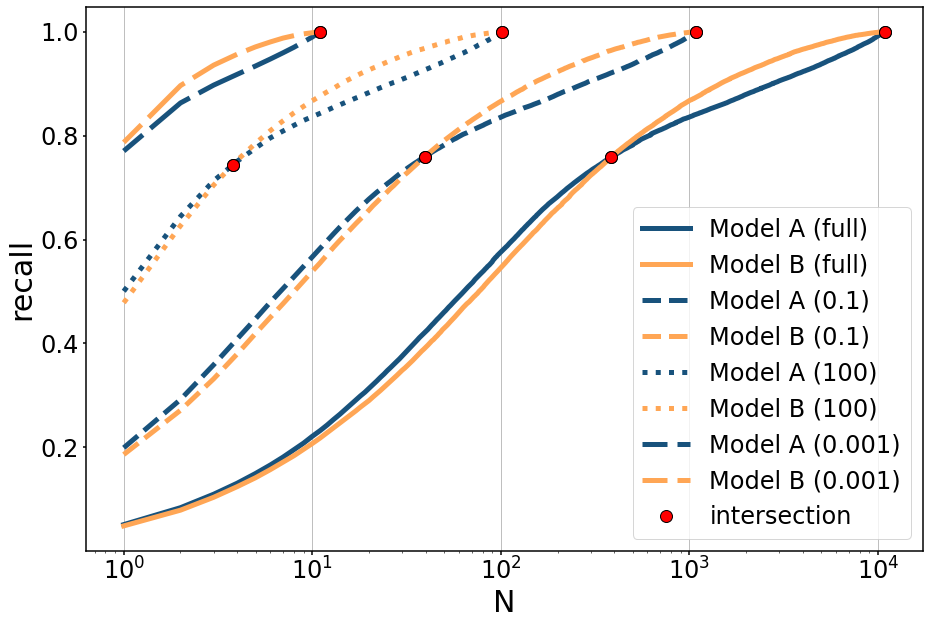

In [6]:
create_plot(ranks_path=ranks_path, models=models, methods=methods, metric="recall", show_intersection=True)

## Plot for MRR values
- When no sampling is used, *Model A* has better MRR scores than *Model B*
- MRR is a top heavy metric:
    - A very large portion of the MRR value will be determined at small cutoff values.
    - It can be seen from the Recall plot, that *Model A* outperforms *Modell B* for small cutoff values across the board, except for 0.001 negative samples
- In this case we can not observe any intersection, instead, we can observe an immediate full model performance reversal at 100 negative and 0.001 negative samples (at least for these specific negative sampling sizes).   

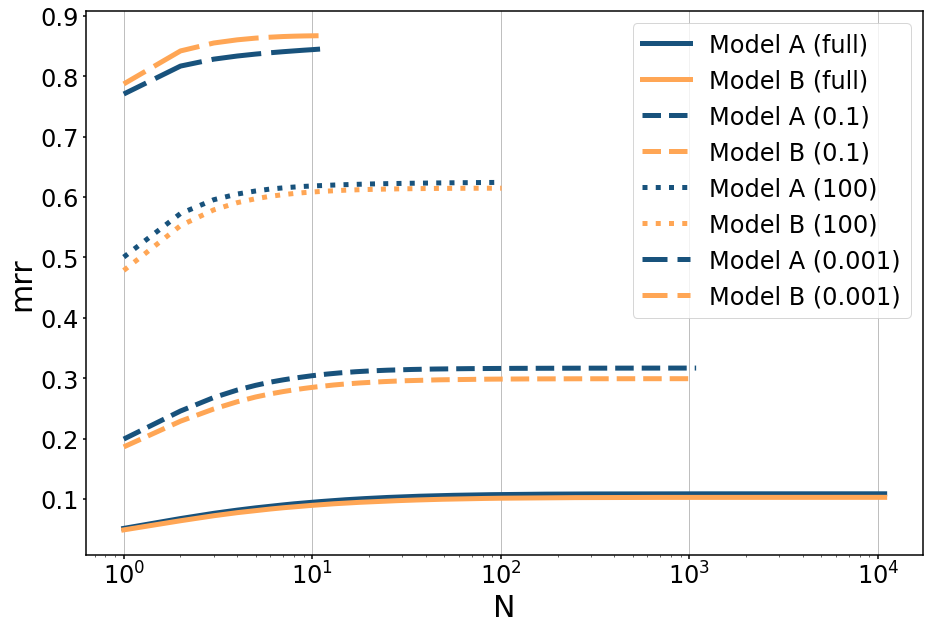

In [7]:
create_plot(ranks_path=ranks_path, models=models, methods=methods, metric="mrr", show_intersection=True)